# <center>TRAINING MODEL</center>


## Import các thư viện hỗ trợ

In [69]:
import pandas as pd
import numpy as np
import math
import re
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV, RepeatedKFold
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor

# Regression models
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, ElasticNet, ElasticNetCV, HuberRegressor, SGDRegressor, RANSACRegressor, PoissonRegressor, TweedieRegressor, Lars, OrthogonalMatchingPursuit, PassiveAggressiveRegressor, TheilSenRegressor, BayesianRidge
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor, VotingRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor

# Classification models
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier

# Clustering
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score

from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)


## Khảo sát dữ liệu

In [3]:
data=pd.read_csv('Data/defined_salary.csv',encoding='utf-8-sig')

In [10]:
data.describe()

,Experience,Education Levels,Job Level,Employment Type: Part-time,Employment Type: Internship,Employment Type: Freelance,Employment Type: Official,Industry: Bán Hàng Kỹ Thuật,Industry: Not specified,Industry: Thương mại điện tử,Industry: accounting_auditing,Industry: administrative_secretarial,Industry: advertising_public_relations_media,Industry: agriculture,Industry: aquaculture_seafood,Industry: architecture,Industry: aviation,Industry: banking,Industry: biotechnology,Industry: chemistry,Industry: construction,Industry: consulting,Industry: customer_service,Industry: education_training,Industry: electricity_electronics_refrigeration / Điện công nghiệp,Industry: entertainment,Industry: environment,Industry: event_organization,Industry: executive_management,Industry: finance_investment,Industry: fine_arts_art_design,Industry: food_beverages,Industry: food_technology_nutrition,Industry: forestry,Industry: healthcare_medical / Thẩm mỹ / Làm đẹp,Industry: household_goods_personal_care,Industry: human_resources,Industry: import_export,Industry: insurance,Industry: interior_exterior_design,...,Industry: pharmaceuticals/ Hóa Mỹ Phẩm,Industry: postal_telecommunications,Industry: printing_publishing,Industry: procurement_supplies,Industry: quality_management_qaqc,Industry: real_estate,Industry: restaurant_hotel,Industry: retail_wholesale,Industry: sales_business,Industry: securities,Industry: security_protection,Industry: statistics,Industry: surveying_geology,Industry: television_journalism_editing,Industry: textile_leather_fashion,Industry: tourism,Industry: translation_interpretation,Industry: transportation_logistics_warehouse,Industry: wooden_goods,Welfare: allowance,Welfare: allowance thâm niên,Welfare: annual_leave,Welfare: bonus,Welfare: business_trip_expenses,Welfare: healthcare,Welfare: insurance,Welfare: laptop,Welfare: not_specified,Welfare: overseas_travel,Welfare: salary_increase,Welfare: shuttle_service,Welfare: sports_club,Welfare: training,Welfare: travel,Welfare: uniform,Language requirement,Gender_requirement_both,Gender_requirement_female,Gender_requirement_male,Salary
count,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.0,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.00000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,...,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,1.100900e+04
mean,1.621492,2.882641,2.255972,0.015805,0.036243,0.009810,0.965664,0.019439,0.0,0.024525,0.107639,0.052048,0.030611,0.004905,0.002271,0.053865,0.002180,0.051594,0.004905,0.010719,0.118812,0.049687,0.081115,0.052775,0.08266,0.002453,0.010173,0.004814,0.031520,0.073031,0.034245,0.034063,0.007267,0.000818,0.044055,0.008175,0.046689,0.033609,0.010355,0.027886,...,0.028340,0.007721,0.003361,0.020438,0.034426,0.052230,0.030248,0.109638,0.297938,0.004269,0.003179,0.003724,0.001998,0.011809,0.036606,0.008811,0.021800,0.050050,0.006994,0.606867,0.302843,0.727223,0.961032,0.442456,0.802889,0.956944,0.356254,0.007448,0.107821,0.939867,0.098011,0.151058,0.954219,0.859842,0.492688,0.298211,0.902534,0.032882,0.064584,1.439821e+07
std,1.502595,1.240091,0.809794,0.124727,0.186903,0.098564,0.182098,0.138067,0.0,0.154681,0.309938,0.222135,0.1

In [12]:
data.columns

Index(['Job Name', 'Company Name', 'Experience', 'Education Levels',
       'Job Level', 'Employment Type: Part-time',
       'Employment Type: Internship', 'Employment Type: Freelance',
       'Employment Type: Official', 'Industry: Bán Hàng Kỹ Thuật',
       ...
       'Welfare: shuttle_service', 'Welfare: sports_club', 'Welfare: training',
       'Welfare: travel', 'Welfare: uniform', 'Language requirement',
       'Gender_requirement_both', 'Gender_requirement_female',
       'Gender_requirement_male', 'Salary'],
      dtype='object', length=101)

In [15]:
data.shape

(11009, 101)

In [17]:
data.duplicated().sum()

np.int64(94)

In [19]:
data=data.drop_duplicates()

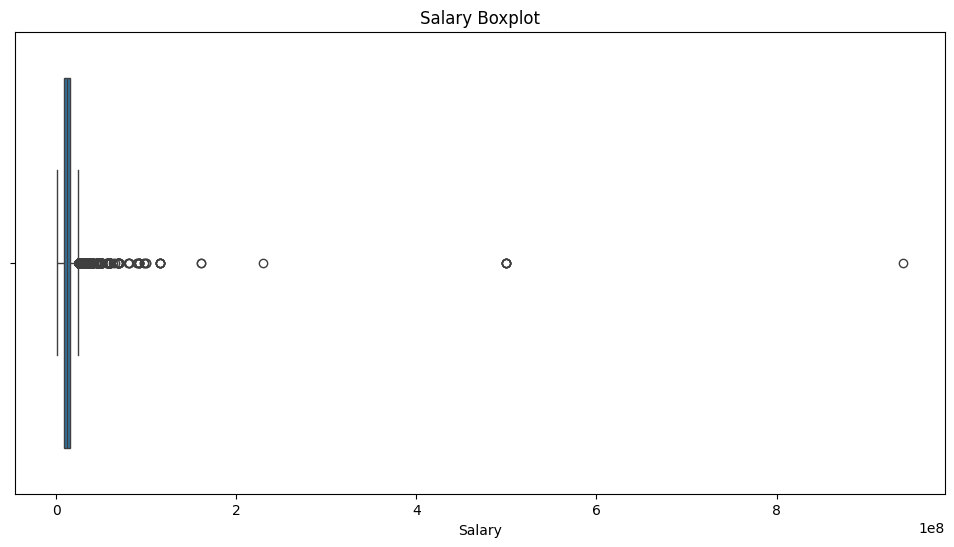

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(x=data['Salary'])
plt.title('Salary Boxplot')
plt.show()

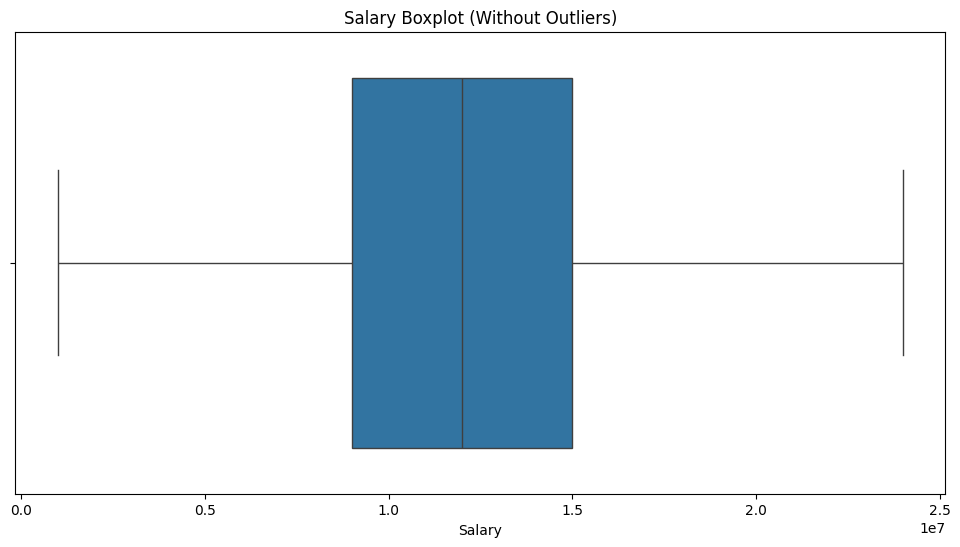

In [40]:
Q1 = data['Salary'].quantile(0.25)
Q3 = data['Salary'].quantile(0.75)
IQR = Q3 - Q1
filtered_salary = data[(data['Salary'] >= Q1 - 1.5 * IQR) & (data['Salary'] <= Q3 + 1.5 * IQR)]['Salary']

plt.figure(figsize=(12,6))
sns.boxplot(x=filtered_salary)
plt.title('Salary Boxplot (Without Outliers)')
plt.show()


In [43]:
filtered_salary.shape

(9865,)

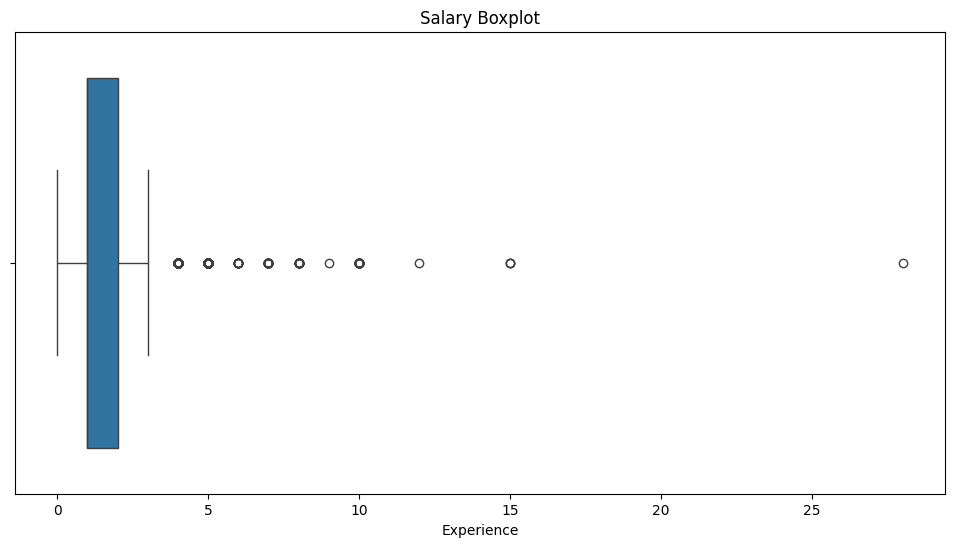

In [42]:
plt.figure(figsize=(12,6))
sns.boxplot(x=data['Experience'])
plt.title('Salary Boxplot')
plt.show()

## Huấn luyện mô hình

In [52]:
numeric_cols=data.select_dtypes([np.number]).columns
data=data[numeric_cols]
data

,Experience,Education Levels,Job Level,Employment Type: Part-time,Employment Type: Internship,Employment Type: Freelance,Employment Type: Official,Industry: Bán Hàng Kỹ Thuật,Industry: Not specified,Industry: Thương mại điện tử,Industry: accounting_auditing,Industry: administrative_secretarial,Industry: advertising_public_relations_media,Industry: agriculture,Industry: aquaculture_seafood,Industry: architecture,Industry: aviation,Industry: banking,Industry: biotechnology,Industry: chemistry,Industry: construction,Industry: consulting,Industry: customer_service,Industry: education_training,Industry: electricity_electronics_refrigeration / Điện công nghiệp,Industry: entertainment,Industry: environment,Industry: event_organization,Industry: executive_management,Industry: finance_investment,Industry: fine_arts_art_design,Industry: food_beverages,Industry: food_technology_nutrition,Industry: forestry,Industry: healthcare_medical / Thẩm mỹ / Làm đẹp,Industry: household_goods_personal_care,Industry: human_resources,Industry: import_export,Industry: insurance,Industry: interior_exterior_design,...,Industry: pharmaceuticals/ Hóa Mỹ Phẩm,Industry: postal_telecommunications,Industry: printing_publishing,Industry: procurement_supplies,Industry: quality_management_qaqc,Industry: real_estate,Industry: restaurant_hotel,Industry: retail_wholesale,Industry: sales_business,Industry: securities,Industry: security_protection,Industry: statistics,Industry: surveying_geology,Industry: television_journalism_editing,Industry: textile_leather_fashion,Industry: tourism,Industry: translation_interpretation,Industry: transportation_logistics_warehouse,Industry: wooden_goods,Welfare: allowance,Welfare: allowance thâm niên,Welfare: annual_leave,Welfare: bonus,Welfare: business_trip_expenses,Welfare: healthcare,Welfare: insurance,Welfare: laptop,Welfare: not_specified,Welfare: overseas_travel,Welfare: salary_increase,Welfare: shuttle_service,Welfare: sports_club,Welfare: training,Welfare: travel,Welfare: uniform,Language requirement,Gender_requirement_both,Gender_requirement_female,Gender_requirement_male,Salary
0,3,4,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,1,0,0,1,1,0,1,1,0,0,25000000.0
1,1,2,4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,1,0,0,0,1,0,0,1,1,1,0,1,0,0,12000000.0
2,2,3,2,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,1,1,0,0,1,0,0,34500000.0
3,0,1,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,0,1,0,0,1,1,1,0,1,0,0,14000000.0
4,0,1,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0,0,0,1,0,0,1,1,1,0,1,0,0,13000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11004,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,1,1,0,0,1,0,0,10000000.0
11005,0,4,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,1,0,0,0,1,0,0,1,1,1,1,1,0,0,7500000.0
11006,0,3,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,1,1,0,0,1,1,1,0,1,0,0,8000000.0
11007,0,4,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [54]:
IQR_factor = 2.8  # Hệ số IQR, tăng giá trị này để giữ lại nhiều dữ liệu hơn

# Tính toán IQR cho biến Salary
Q1 = data['Salary'].quantile(0.25)
Q3 = data['Salary'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - IQR_factor * IQR
upper_bound = Q3 + IQR_factor * IQR

# Lọc dữ liệu để loại bỏ ít ngoại lai hơn
data = data[(data['Salary'] >= lower_bound) & (data['Salary'] <= upper_bound)]
data.columns = data.columns.str.replace(r'[\s:]', '_', regex=True)

data.shape

(10522, 99)

In [63]:
X = data.drop('Salary', axis=1)
y=data['Salary']


kf = KFold(n_splits=5, shuffle=True, random_state=42)

def train_and_evaluate_cv(models_dict, X, y, kf):
    results = {}
    for model_name, model in models_dict.items():
        mae_list, mse_list, rmse_list, r2_list = [], [], [], []
        for train_idx, test_idx in kf.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            mae_list.append(mean_absolute_error(y_test, y_pred))
            mse_list.append(mean_squared_error(y_test, y_pred))
            rmse_list.append(np.sqrt(mse_list[-1]))
            r2_list.append(r2_score(y_test, y_pred))
        results[model_name] = {
            "MAE": np.mean(mae_list),
            "MSE": np.mean(mse_list),
            "RMSE": np.mean(rmse_list),
            "R²": np.mean(r2_list)
        }
        print(f"{model_name}: MAE={np.mean(mae_list)}, MSE={np.mean(mse_list)}, RMSE={np.mean(rmse_list)}, R²={np.mean(r2_list)}")
    return results

# Example usage:
# models_dict = {'LinearRegression': LinearRegression(), ...}
# train_and_evaluate_cv(models_dict, X, y, kf)

In [68]:
scaler = StandardScaler()
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1)).ravel()  # ravel() để đưa về 1D

### Nhóm các mô hình tuyến tính

In [77]:
linear_models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "ElasticNet Regression": ElasticNet(),
}
linear_results = train_and_evaluate_cv(linear_models, X, pd.Series(y_scaled), kf)


Linear Regression: MAE=0.5094188583212957, MSE=0.4719386867171978, RMSE=0.6868565420192592, R²=0.5275769181446651
Ridge Regression: MAE=0.5092863874965403, MSE=0.4717490270157251, RMSE=0.6867179919581965, R²=0.5277685803725187
Lasso Regression: MAE=0.7731058405504303, MSE=1.0001661224742548, RMSE=0.9997668714479531, R²=-0.0004843238458731136
ElasticNet Regression: MAE=0.6963983713822336, MSE=0.8239030294999319, RMSE=0.9073620458823373, R²=0.17598202231573112


### Nhóm các mô hình phi tuyến

In [70]:
non_linear_models = {
    "Support Vector Regression (SVR)": SVR(),
    "LinearSVR": LinearSVR(),
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "KNeighbors Regressor": KNeighborsRegressor(),
    "MLP Regressor": MLPRegressor(),
    "Gaussian Process Regressor": GaussianProcessRegressor()
}
# Đánh giá các mô hình học máy phi tuyến
non_linear_results = train_and_evaluate_cv(non_linear_models, X, pd.Series(y_scaled), kf)

Support Vector Regression (SVR): MAE=0.4587182800712557, MSE=0.427987194968017, RMSE=0.654054067627563, R²=0.5715904275062467
LinearSVR: MAE=0.4999323166394586, MSE=0.48752670389790176, RMSE=0.6981340048589534, R²=0.5118327994169084
Decision Tree Regressor: MAE=0.5651008877938368, MSE=0.7234752759572693, RMSE=0.8499562702698598, R²=0.27595148833370486
KNeighbors Regressor: MAE=0.4804316315024365, MSE=0.46666313356356987, RMSE=0.6829374436879458, R²=0.533015649774897
MLP Regressor: MAE=0.530345510826993, MSE=0.5333939174758575, RMSE=0.7301581871377424, R²=0.4659603179232339
Gaussian Process Regressor: MAE=0.47794166739675265, MSE=0.47687417589732706, RMSE=0.6904205580537436, R²=0.5227025849145186


### Nhóm mô hình đặc biệt

In [72]:
# Các mô hình đặc biệt
special_models = {
    "Huber Regressor": HuberRegressor(),
    "RANSAC Regressor": RANSACRegressor(),
    "SGD Regressor": SGDRegressor(),
    "Passive Aggressive Regressor": PassiveAggressiveRegressor(),
    "Bayesian Ridge Regression": BayesianRidge()
}
# Đánh giá các mô hình đặc biệt: 
special_results = train_and_evaluate_cv(special_models, X, pd.Series(y_scaled), kf)

Huber Regressor: MAE=0.4997888167266888, MSE=0.47860695680286414, RMSE=0.6916908592669395, R²=0.5208686365851023
RANSAC Regressor: MAE=0.681820182562272, MSE=0.8651163798813887, RMSE=0.9277114686207654, R²=0.13241402931820423
SGD Regressor: MAE=0.5238110897728125, MSE=0.48673752601237474, RMSE=0.6974998443819012, R²=0.5126002629896925
Passive Aggressive Regressor: MAE=0.7373640713385103, MSE=0.9969150708920752, RMSE=0.9642872903563866, R²=-0.01568724266020587
Bayesian Ridge Regression: MAE=0.5084559330517016, MSE=0.47087326418853087, RMSE=0.6860793732982011, R²=0.5286386988752667


### Nhóm mô hình cây

In [73]:
# Các mô hình cây (tree-based models)
tree_models = {
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "Gradient Boosting Regressor": GradientBoostingRegressor(),
    "XGBoost Regressor": XGBRegressor(),
    "LightGBM Regressor": LGBMRegressor(),
    "ExtraTrees Regressor": ExtraTreesRegressor(),
    "HistGradientBoosting Regressor": HistGradientBoostingRegressor(),
    "Bagging Regressor": BaggingRegressor()
}
# Đánh giá các mô hình cây (tree-based models)
tree_results = train_and_evaluate_cv(tree_models, X, pd.Series(y_scaled), kf)

Decision Tree Regressor: MAE=0.5660959914608383, MSE=0.7227128154149665, RMSE=0.8497691732286603, R²=0.27633147080555204
Random Forest Regressor: MAE=0.45061485920682554, MSE=0.41816147617076077, RMSE=0.6465236178890994, R²=0.5814537011389328
Gradient Boosting Regressor: MAE=0.4848885767017593, MSE=0.43075300487817153, RMSE=0.6561381326651621, R²=0.5689357596500473
XGBoost Regressor: MAE=0.4600628318055352, MSE=0.4118060655192135, RMSE=0.641609127317591, R²=0.5876671464408216
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 198
[LightGBM] [Info] Number of data points in the train set: 8417, number of used features: 88
[LightGBM] [Info] Start training from score -0.004915
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001606 seconds.
You can se

### Nhóm mô hình tăng cường

In [74]:
# Các mô hình tăng cường (ensemble models)
ensemble_models = {
    "AdaBoost Regressor": AdaBoostRegressor(),
    "Bagging Regressor": BaggingRegressor(),
    #"CatBoost Regressor": CatBoostRegressor(verbose=0),
    "Voting Regressor":  VotingRegressor(estimators=[
            ('lr', LinearRegression()),
            ('ridge', Ridge(alpha=1.0)),
            ('lasso', Lasso(alpha=0.1)),
            ('svr', SVR(C=1.0, kernel='rbf')),
            ('dt', DecisionTreeRegressor(max_depth=5)),
            ('knn', KNeighborsRegressor(n_neighbors=5))
        ]),
    "Stacking Regressor": StackingRegressor(
            estimators=[
                ('lr', LinearRegression()),
                ('ridge', Ridge(alpha=1.0)),
                ('lasso', Lasso(alpha=0.1)),
                ('svr', SVR(C=1.0, kernel='rbf')),
                ('dt', DecisionTreeRegressor(max_depth=5)),
                ('knn', KNeighborsRegressor(n_neighbors=5))
            ],
            final_estimator=LinearRegression() 
        )
}
# Đánh giá các mô hình Ensemble
emsemble_results = train_and_evaluate_cv(ensemble_models, X, pd.Series(y_scaled), kf)

AdaBoost Regressor: MAE=0.6749276196261219, MSE=0.6589519360093488, RMSE=0.8113165303071173, R²=0.34058887130448096
Bagging Regressor: MAE=0.4690508067966975, MSE=0.4536168265696248, RMSE=0.6734603009705139, R²=0.545512930798391
Voting Regressor: MAE=0.4809520798406708, MSE=0.4315724366568069, RMSE=0.6567824387982195, R²=0.5680874738880929
Stacking Regressor: MAE=0.46008634843623775, MSE=0.40812806034398363, RMSE=0.6386818876911144, R²=0.5915688820452266


## So sánh hiệu suất tổng thể

In [83]:
concat_result={**linear_results,**tree_results,**emsemble_results,**special_results,**non_linear_results,**emsemble_results}
models_name=list(concat_result.keys())
mae_values=[concat_result[model_name]['MAE'] for model_name in models_name]
mse_values = [concat_result[model]["MSE"] for model in models_name]
rmse_values = [concat_result[model]["RMSE"] for model in models_name]
r2_values = [concat_result[model]["R²"] for model in models_name]

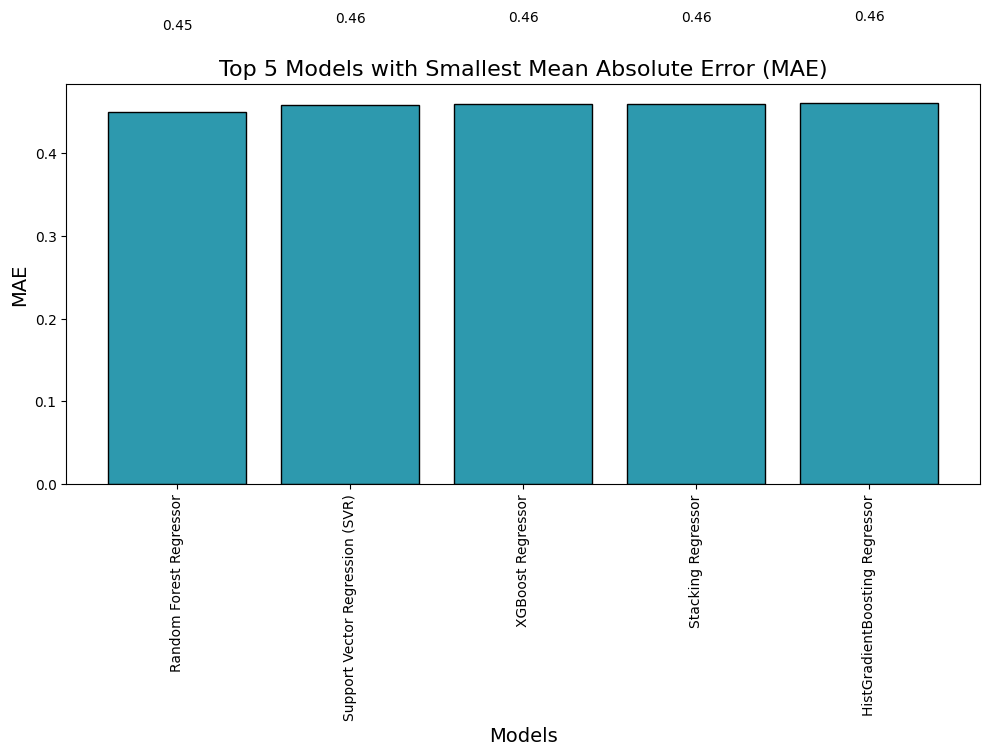

In [87]:
top_5_models_indices = np.argsort(mae_values)[:5]
top_5_model_names = [models_name[i] for i in top_5_models_indices]
top_5_mae_values = [mae_values[i] for i in top_5_models_indices]
plt.figure(figsize=(10, 8))  # Giảm kích thước biểu đồ

# Vẽ cột biểu đồ cho 5 mô hình có MAE nhỏ nhất
plt.bar(top_5_model_names, top_5_mae_values, color='#2d99ae', edgecolor='black')

# Thêm tiêu đề và nhãn
plt.title('Top 5 Models with Smallest Mean Absolute Error (MAE)', fontsize=16)
plt.xticks(rotation =90)
plt.xlabel('Models', fontsize=14)
plt.ylabel('MAE', fontsize=14)
for i, v in enumerate(top_5_mae_values):
    plt.text(i, v + 0.1, f"{v:.2f}", ha='center', fontsize=10)
plt.tight_layout()
plt.show()

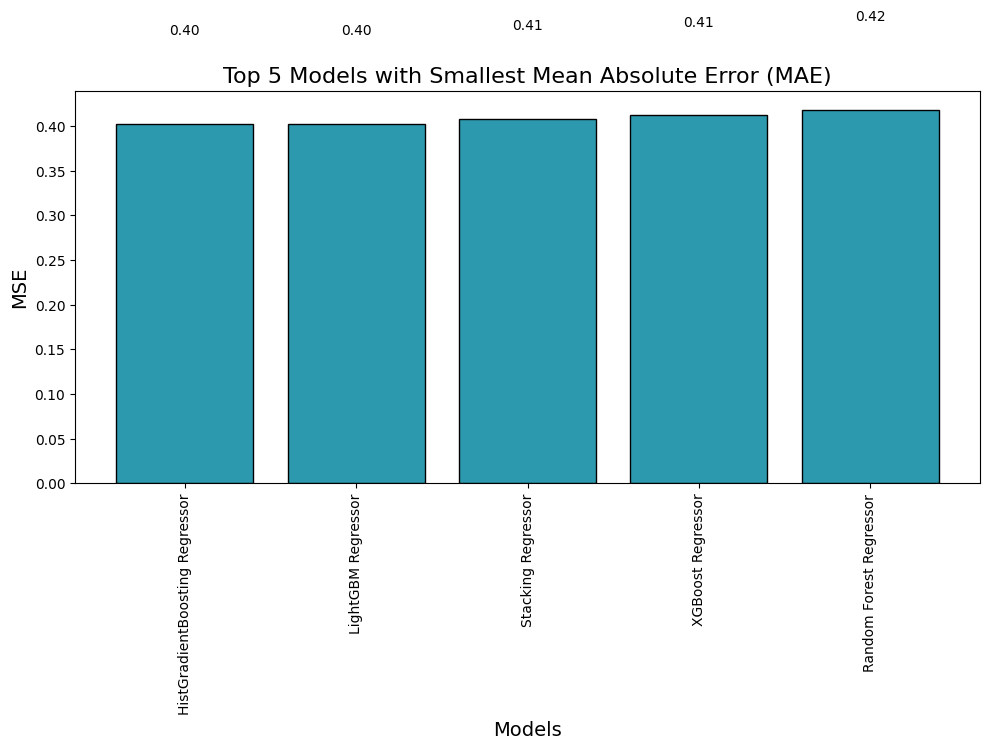

In [88]:
top_5_models_indices = np.argsort(mse_values)[:5]
top_5_model_names = [models_name[i] for i in top_5_models_indices]
top_5_mae_values = [mse_values[i] for i in top_5_models_indices]
plt.figure(figsize=(10, 8))  # Giảm kích thước biểu đồ

# Vẽ cột biểu đồ cho 5 mô hình có MAE nhỏ nhất
plt.bar(top_5_model_names, top_5_mae_values, color='#2d99ae', edgecolor='black')

# Thêm tiêu đề và nhãn
plt.title('Top 5 Models with Smallest Mean Absolute Error (MAE)', fontsize=16)
plt.xticks(rotation =90)
plt.xlabel('Models', fontsize=14)
plt.ylabel('MSE', fontsize=14)
for i, v in enumerate(top_5_mae_values):
    plt.text(i, v + 0.1, f"{v:.2f}", ha='center', fontsize=10)
plt.tight_layout()
plt.show()

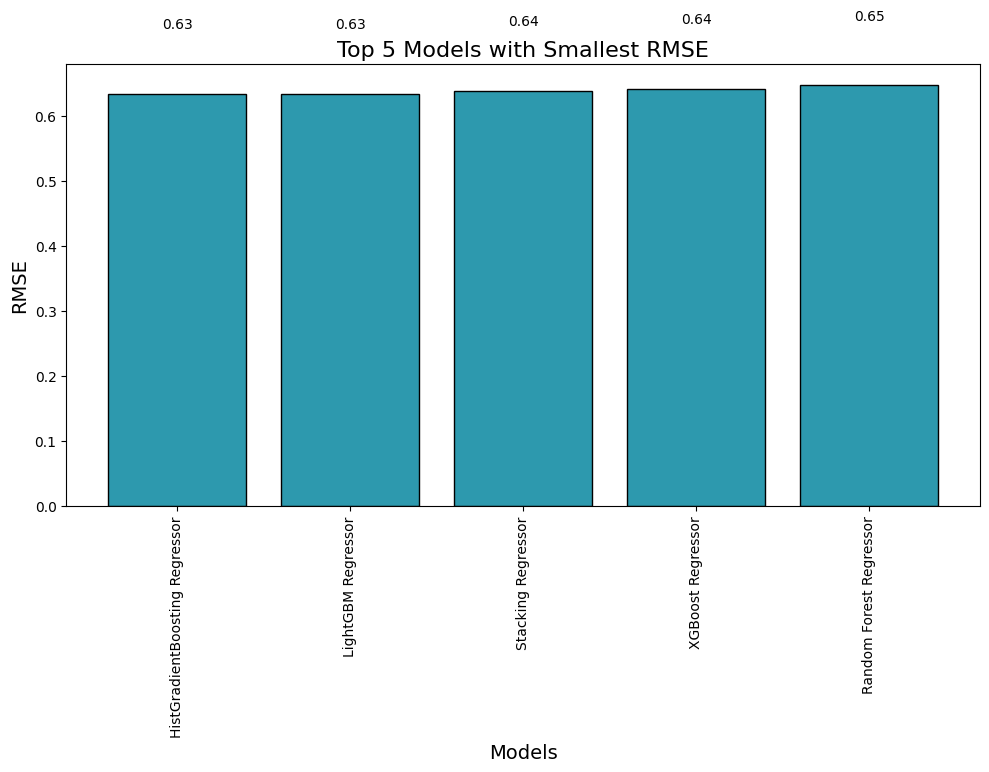

In [89]:
# Chọn 5 mô hình có RMSE nhỏ nhất
top_5_models_indices = np.argsort(rmse_values)[:5]
top_5_model_names = [models_name[i] for i in top_5_models_indices]
top_5_rmse_values = [rmse_values[i] for i in top_5_models_indices]

# Vẽ biểu đồ RMSE cho 5 mô hình có RMSE nhỏ nhất
plt.figure(figsize=(10, 8))  # Giảm kích thước biểu đồ

# Vẽ cột biểu đồ cho 5 mô hình có RMSE nhỏ nhất
plt.bar(top_5_model_names, top_5_rmse_values, color='#2d99ae', edgecolor='black')

# Thêm tiêu đề và nhãn
plt.title('Top 5 Models with Smallest RMSE', fontsize=16)
plt.xticks(rotation =90)
plt.xlabel('Models', fontsize=14)
plt.ylabel('RMSE', fontsize=14)

# Hiển thị giá trị MAE trên cột
for i, v in enumerate(top_5_rmse_values):
    plt.text(i, v + 0.1, f"{v:.2f}", ha='center', fontsize=10)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

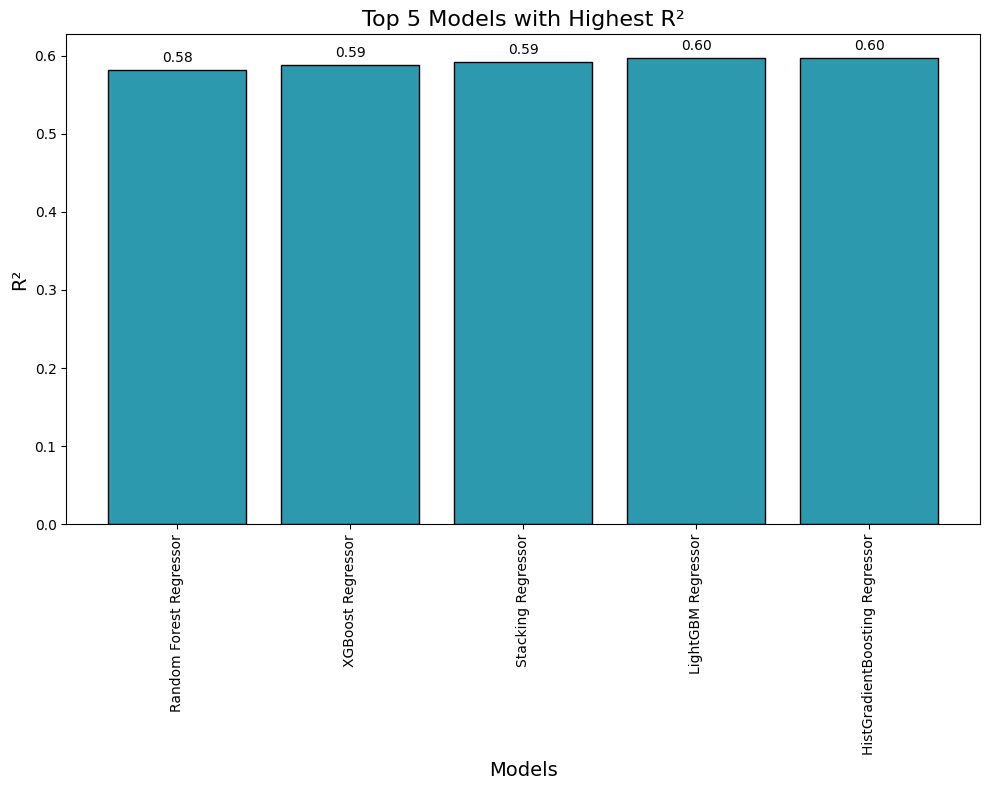

In [90]:
# Lấy chỉ mục của 5 mô hình có R² cao nhất
top_5_models_indices = np.argsort(r2_values)[-5:]  # Lấy 5 chỉ mục cuối cùng (R² cao nhất)
top_5_model_names = [models_name[i] for i in top_5_models_indices]  # Tên mô hình
top_5_r2_values = [r2_values[i] for i in top_5_models_indices]  # Giá trị R² của các mô hình
# Vẽ biểu đồ R² cho 5 mô hình có R² cao nhất
plt.figure(figsize=(10, 8))  # Giảm kích thước biểu đồ
# Vẽ cột biểu đồ cho 5 mô hình có R² cao nhất
plt.bar(top_5_model_names, top_5_r2_values, color='#2d99ae', edgecolor='black')
# Thêm tiêu đề và nhãn
plt.title('Top 5 Models with Highest R²', fontsize=16)
plt.xticks(rotation=90)
plt.xlabel('Models', fontsize=14)
plt.ylabel('R²', fontsize=14)
# Hiển thị giá trị R² trên cột
for i, v in enumerate(top_5_r2_values):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontsize=10)
# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

In [91]:
# Tìm mô hình tốt nhất dựa trên MAE, RMSE và R²
best_mae_model = min(concat_result, key=lambda model: concat_result[model]["MAE"])
best_mse_model = min(concat_result, key=lambda model: concat_result[model]["MSE"])
best_rmse_model = min(concat_result, key=lambda model: concat_result[model]["RMSE"])
best_r2_model = max(concat_result, key=lambda model: concat_result[model]["R²"])

# In kết quả
print(f"Mô hình có MAE thấp nhất: {best_mae_model} với MAE = {concat_result[best_mae_model]['MAE']}")
print(f"Mô hình có MSE thấp nhất: {best_mse_model} với MSE = {concat_result[best_mse_model]['MSE']}")
print(f"Mô hình có RMSE thấp nhất: {best_rmse_model} với RMSE = {concat_result[best_rmse_model]['RMSE']}")
print(f"Mô hình có R² cao nhất: {best_r2_model} với R² = {concat_result[best_r2_model]['R²']}")

Mô hình có MAE thấp nhất: Random Forest Regressor với MAE = 0.45061485920682554
Mô hình có MSE thấp nhất: HistGradientBoosting Regressor với MSE = 0.40213769895146256
Mô hình có RMSE thấp nhất: HistGradientBoosting Regressor với RMSE = 0.6340321192246403
Mô hình có R² cao nhất: HistGradientBoosting Regressor với R² = 0.5974539171944002


In [92]:
# Định nghĩa trọng số cho các chỉ số
w1 = 0.25  # Trọng số cho MAE
w2 = 0.25  # Trọng số cho RMSE
w3 = 0.25  # Trọng số cho MSE
w4 = 0.25  # Trọng số cho R²

# Tính MAE min, RMSE min, MSE min, và R² min/max từ tất cả các mô hình
mae_min = min(concat_result[model]["MAE"] for model in concat_result)
mae_max = max(concat_result[model]["MAE"] for model in concat_result)

rmse_min = min(concat_result[model]["RMSE"] for model in concat_result)
rmse_max = max(concat_result[model]["RMSE"] for model in concat_result)

mse_min = min(concat_result[model]["MSE"] for model in concat_result)
mse_max = max(concat_result[model]["MSE"] for model in concat_result)

r2_min = min(concat_result[model]["R²"] for model in concat_result)  # R² càng cao càng tốt
r2_max = max(concat_result[model]["R²"] for model in concat_result)

# Tính chỉ số tổng hợp cho mỗi mô hình
model_scores = {}
for model in concat_result:
    # Chuẩn hóa các chỉ số
    normalized_mae = (concat_result[model]["MAE"] - mae_min) / (mae_max - mae_min)
    normalized_rmse = (concat_result[model]["RMSE"] - rmse_min) / (rmse_max - rmse_min)
    normalized_mse = (concat_result[model]["MSE"] - mse_min) / (mse_max - mse_min)
    normalized_r2 = (concat_result[model]["R²"] - r2_min) / (r2_max - r2_min)

    # Tính điểm tổng hợp theo trọng số
    score = (
        w1 * (1 - normalized_mae) +  # MAE nhỏ hơn là tốt hơn
        w2 * (1 - normalized_rmse) +  # RMSE nhỏ hơn là tốt hơn
        w3 * (1 - normalized_mse) +  # MSE nhỏ hơn là tốt hơn
        w4 * normalized_r2           # R² lớn hơn là tốt hơn
    )
    model_scores[model] = score

# Chọn mô hình tốt nhất (mô hình có score cao nhất)
best_model = max(model_scores, key=model_scores.get)

# In kết quả
print(f"Mô hình tốt nhất là: {best_model} với chỉ số tổng hợp = {model_scores[best_model]}")


Mô hình tốt nhất là: HistGradientBoosting Regressor với chỉ số tổng hợp = 0.9920079330290711


## Cải thiện mô hình

In [112]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def training_best_model(model,X,y):
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
    rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
    hgb=model
    param_grid = {
    'max_iter': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_regularization': [0.0, 0.1, 1.0]
    }

    grid_search = GridSearchCV(
        estimator=hgb,
        param_grid=param_grid,
        cv=rkf,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train,y_train)
    best_hgb = grid_search.best_estimator_
    
    y_pred=best_hgb.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f"Best HistGradientBoostingRegressor: MAE={mae}, MSE={mse}, RMSE={rmse}, R²={r2}")
    return best_hgb
best_model=HistGradientBoostingRegressor()
best_hgb=training_best_model(best_model,X,pd.Series(y_scaled))



Fitting 15 folds for each of 108 candidates, totalling 1620 fits
Best HistGradientBoostingRegressor: MAE=0.4574147008329325, MSE=0.41307069906773636, RMSE=0.6427057639913745, R²=0.5955645569264427


In [115]:
predict_data=pd.read_csv('Data/Undefined_salary.csv',encoding='utf-8-sig')
predict_data.shape

(8462, 101)

In [116]:
numeric_cols=predict_data.select_dtypes([np.number]).columns
predict_data=predict_data[numeric_cols]

In [120]:
data

,Experience,Education_Levels,Job_Level,Employment_Type__Part-time,Employment_Type__Internship,Employment_Type__Freelance,Employment_Type__Official,Industry__Bán_Hàng_Kỹ_Thuật,Industry__Not_specified,Industry__Thương_mại_điện_tử,Industry__accounting_auditing,Industry__administrative_secretarial,Industry__advertising_public_relations_media,Industry__agriculture,Industry__aquaculture_seafood,Industry__architecture,Industry__aviation,Industry__banking,Industry__biotechnology,Industry__chemistry,Industry__construction,Industry__consulting,Industry__customer_service,Industry__education_training,Industry__electricity_electronics_refrigeration_/_Điện_công_nghiệp,Industry__entertainment,Industry__environment,Industry__event_organization,Industry__executive_management,Industry__finance_investment,Industry__fine_arts_art_design,Industry__food_beverages,Industry__food_technology_nutrition,Industry__forestry,Industry__healthcare_medical_/_Thẩm_mỹ_/_Làm_đẹp,Industry__household_goods_personal_care,Industry__human_resources,Industry__import_export,Industry__insurance,Industry__interior_exterior_design,...,Industry__pharmaceuticals/_Hóa_Mỹ_Phẩm,Industry__postal_telecommunications,Industry__printing_publishing,Industry__procurement_supplies,Industry__quality_management_qaqc,Industry__real_estate,Industry__restaurant_hotel,Industry__retail_wholesale,Industry__sales_business,Industry__securities,Industry__security_protection,Industry__statistics,Industry__surveying_geology,Industry__television_journalism_editing,Industry__textile_leather_fashion,Industry__tourism,Industry__translation_interpretation,Industry__transportation_logistics_warehouse,Industry__wooden_goods,Welfare__allowance,Welfare__allowance_thâm_niên,Welfare__annual_leave,Welfare__bonus,Welfare__business_trip_expenses,Welfare__healthcare,Welfare__insurance,Welfare__laptop,Welfare__not_specified,Welfare__overseas_travel,Welfare__salary_increase,Welfare__shuttle_service,Welfare__sports_club,Welfare__training,Welfare__travel,Welfare__uniform,Language_requirement,Gender_requirement_both,Gender_requirement_female,Gender_requirement_male,Salary
0,3,4,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,1,0,0,1,1,0,1,1,0,0,25000000.0
1,1,2,4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,1,0,0,0,1,0,0,1,1,1,0,1,0,0,12000000.0
3,0,1,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,0,1,0,0,1,1,1,0,1,0,0,14000000.0
4,0,1,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0,0,0,1,0,0,1,1,1,0,1,0,0,13000000.0
5,2,3,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,1,1,1,1,0,1,1,0,1,1,1,1,1,1,0,0,20000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11004,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,1,1,0,0,1,0,0,10000000.0
11005,0,4,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,1,0,0,0,1,0,0,1,1,1,1,1,0,0,7500000.0
11006,0,3,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,1,1,0,0,1,1,1,0,1,0,0,8000000.0
11007,0,4,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [121]:
predict_data.columns = predict_data.columns.str.replace(r'[\s:]', '_', regex=True)

In [122]:
y_pred = best_hgb.predict(predict_data)

In [126]:
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).ravel()

In [127]:
predict_data['Prediction']=y_pred

In [128]:
y_pred


array([14473066.92198783, 15310825.95211146, 13026290.04752263, ...,
        9245486.95255703,  8265118.2628597 ,  8879596.37707117],
      shape=(8462,))

In [ ]:
predict_data.to_csv('Data/Predict_Competition_Salary.csv',encoding='utf-8-sig')